In [187]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import sys
import pycce as pc
import ase
from ase.build import bulk

from mpl_toolkits import mplot3d

seed = 8805
np.random.seed(seed)
np.set_printoptions(suppress=True, precision=5)

In [188]:
# Generate unitcell from ase
diamond = bulk('C', 'diamond', cubic=True)
diamond = pc.read_ase(diamond)

In [189]:
# Populate Bath cell with isotopes
diamond.add_isotopes(('13C', 0.011))

defaultdict(dict, {'C': {'13C': 0.011}})

In [190]:
# Set z-direction of the bath (defect)
diamond.zdir = [1, 1, 1]

In [191]:
# Generate spin bath
### Add the defect. remove and add atoms at the positions (in cell coordinates)
atoms = diamond.gen_supercell(200, remove=[('C', [0., 0, 0]),
                                           ('C', [0.5, 0.5, 0.5])],
                              add=('14N', [0.5, 0.5, 0.5]),
                              seed=seed)

# Note, that because the 14C isotope doesn’t have a spin, PyCCE does not find it in common isotopes, and raises a warning. We have to provide SpinType for it separately, or define the properties as follows:
atoms['14C'].gyro = 0
atoms['14C'].spin = 0

In [212]:
# Setting up the Simulator

### Parameters of CCE calculations engine
# Order of CCE aproximation
order = 2
# Bath cutoff radius
r_bath = 40  # in A
# Cluster cutoff radius
r_dipole = 8  # in A

# position of central spin
position = [0, 0, 0]
# Qubit levels (in Sz basis)
alpha = [0, 0, 1]; beta = [0, 1, 0]
# ZFS Parametters of NV center in diamond
D = 1.88 * 1e10 # in kHz
E = 0 # in kHz
nv = pc.CenterArray(spin=1, position=position, D=D, E=E, alpha=alpha, beta=beta)

# The code already knows most exsiting isotopes.
#              Bath spin types
#              name    spin    gyro       quadrupole (for s>1/2)
spin_types = [('14N',  1,      1.9338,    20.44),
              ('13C',  1 / 2,  6.72828),
              ('29Si', 1 / 2, -5.3188),]
atoms.add_type(*spin_types)

In [213]:
print(nv)

CenterArray
(s: [1.],
xyz:
[[0. 0. 0.]],
zfs:
[[[-6.26667e+09  0.00000e+00  0.00000e+00]
  [ 0.00000e+00 -6.26667e+09  0.00000e+00]
  [ 0.00000e+00  0.00000e+00  1.25333e+10]]],
gyro:
[[[-17608.59705     -0.          -0.     ]
  [    -0.      -17608.59705     -0.     ]
  [    -0.          -0.      -17608.59705]]])


In [214]:
# Setting the Simulator object
### Setting the runner engine
calc = pc.Simulator(spin=nv, bath=atoms, D=D,
                    r_bath=r_bath, r_dipole=r_dipole, order=order)

In [215]:
# calc.set_zfs(D=D, E=E)

In [216]:
print(calc)

Simulator for center array of size 1.
magnetic field:
array([0., 0., 0.])

Parameters of cluster expansion:
r_bath: 40
r_dipole: 8
order: 2

Bath consists of 506 spins.

Clusters include:
506  clusters of order 1.
876  clusters of order 2.



In [217]:
# Taking advantage of subclassing np.ndarray we can change in situ the quadrupole tensor of the Nitrogen nuclear spin.
nspin = calc.bath
# Set model quadrupole tensor at N atom
quad = np.asarray([[-2.5, 0, 0],
                   [0, -2.5, 0],
                   [0, 0,  5.0]]) * 1e3 * 2 * np.pi

nspin['Q'][nspin['N'] == '14N'] = quad

In [218]:
print(calc)

Simulator for center array of size 1.
magnetic field:
array([0., 0., 0.])

Parameters of cluster expansion:
r_bath: 40
r_dipole: 8
order: 2

Bath consists of 506 spins.

Clusters include:
506  clusters of order 1.
876  clusters of order 2.



In [219]:
# Time points
time_space = np.linspace(0, 2, 201)  # in ms
# Number of pulses in CPMG seq (0 = FID, 1 = HE)
n = 1
# Mag. Field (Bx By Bz)
b = np.array([0, 0, 500])  # in G

# Hahn-echo pulse sequence
pulse_sequence = [pc.Pulse('x', np.pi)]

# Calculate coherence function
l_generatilze = calc.compute(time_space, magnetic_field=0,
                             pulses=pulse_sequence,
                             method='gcce', quantity='coherence')

In [220]:
calc.compute(time_space, magnetic_field=0,
             pulses=pulse_sequence,
             method='gcce',
             quantity='coherence')


array([ 1.     +0.j     ,  0.99992-0.j     ,  0.99911+0.j     ,
        0.99641-0.j     ,  0.98975+0.j     ,  0.97754-0.j     ,
        0.95718-0.j     ,  0.92714+0.j     ,  0.88862+0.00001j,
        0.84025-0.j     ,  0.77875-0.00003j,  0.71152+0.00003j,
        0.63892-0.00001j,  0.56112+0.00001j,  0.48558+0.j     ,
        0.40955-0.00005j,  0.34011+0.00004j,  0.28078+0.00001j,
        0.22685-0.00002j,  0.18056-0.00003j,  0.14563+0.00001j,
        0.11818-0.j     ,  0.09652-0.00002j,  0.08078-0.00001j,
        0.06757-0.00005j,  0.05878+0.00002j,  0.05294-0.00003j,
        0.04635-0.00006j,  0.04088-0.00003j,  0.03674-0.00005j,
        0.03263-0.00003j,  0.02904-0.00006j,  0.02518-0.00006j,
        0.02069-0.00006j,  0.01759-0.00003j,  0.01472-0.00004j,
        0.01146-0.00006j,  0.00916-0.00002j,  0.00729-0.00003j,
        0.00567-0.00002j,  0.0045 -0.00002j,  0.00339-0.00002j,
        0.00253-0.00001j,  0.00206-0.00001j,  0.00157-0.00001j,
        0.00113-0.00001j,  0.00087-0.j  

/Users/markoneill/Desktop/Physics/SS/Capstone/VScode Capstone Folder/Capstone_environment/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


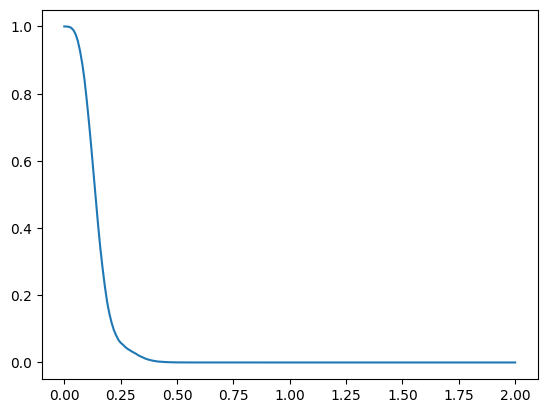

In [221]:
plt.plot(time_space,l_generatilze)

In [34]:
# Generate the BathCell object. Here we use the interface with ase which can effortlessly generate unit cells of many materials. As an example, we import the diamond structure.
cell = pc.BathCell.from_ase(bulk('C', 'diamond', cubic=True))

# Using the BathCell object, generate spin bath of the most common isotopes in the material. Here we generate the spin bath of size 200 Angstrom and remove one carbon, where the spin of interest is located, from the diamond crystal lattice.
# This function returns the BathArray instance, which contains names of the bath spins in 'N', their coordinates in angstrom in 'xyz', empty arrays of hyperfine couplings in kHz in 'A', and quadrupole couplings in kHz in 'Q' namefields. The hyperfine couplings will be generated by Simulator in the next step. For alternative ways to define hyperfine couplings see Hamiltonian Parameters Input.
atoms = cell.gen_supercell(200, remove=('C', [0, 0, 0]))

# Setup the Simulator using the generated spin bath. The first required argument spin is the total spin of the central spin or the CenterArray instance, containing properties of the central spins. r_bath, r_dipole and order are convergence parameters (see the Tutorials for examples of convergence), magnetic_field is the external applied magnetic field along the z-axis, and pulses is the number of decoupling (pi) pulses in Carr-Purcell-Meiboom-Gill (CPMG) sequence or a more complicated sequence, set with Pulse objects.
# The hyperfine couplings are automatically generated at this step assuming point dipole-dipole interactions between central spin and bath spins.
calc = pc.Simulator(spin=1, position=[0, 0, 0], bath=atoms, r_bath=40,
                    r_dipole=6, order=2, magnetic_field=500, pulses=1)

In [35]:
# Compute the coherence function of the qubit using .compute method of the Simulator object with conventional CCE.
time_points = np.linspace(0, 2, 101)
coherence = calc.compute(time_points)

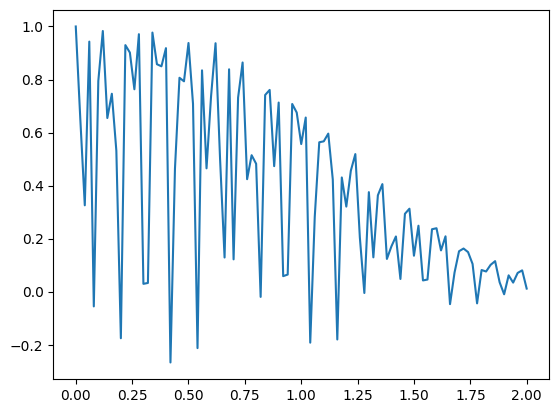

In [36]:
# Plotting the coherence as a function of time.
plt.plot(time_points, coherence)